In [49]:
import numpy as np
import pickle
import os

def load_cifar10_batches(folder_path):
    train_images = []
    train_labels = []
    
    # Load all training batches
    for i in range(1, 6):
        file_path = os.path.join(folder_path, f'data_batch_{i}')
        with open(file_path, 'rb') as file:
            batch = pickle.load(file, encoding='latin1')
        images = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        labels = batch['labels']
        
        train_images.append(images)
        train_labels.append(labels)
    
    # Combine all training batches
    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)
    
    # Load test batch
    test_path = os.path.join(folder_path, r'C:\DL\cifar-10-batches-py\test_batch')
    with open(test_path, 'rb') as file:
        test_batch = pickle.load(file, encoding='latin1')
    test_images = test_batch['data'].reshape((len(test_batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch['labels'])
    
    return train_images, train_labels, test_images, test_labels

# Example usage
train_images, train_labels, test_images, test_labels = load_cifar10_batches(r'C:\DL\cifar-10-batches-py')
print("Training images shape:", train_images.shape)
print("Test images shape:", test_images.shape)

Training images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)


In [50]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Convert labels to categorical one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(train_images)
# Now, let's print the shape to confirm
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of train_labels: (50000, 10)
Shape of test_labels: (10000, 10)


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, GlobalAveragePooling1D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers
def create_base_model():
    model = Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(10, activation='softmax')
    ])
    return model

def rnn_model():
    inputs = Input(shape=(32, 32, 3))
    x = layers.Reshape(target_shape=(32, 96))(inputs)  # Combine color channels and width into sequence
    x = LSTM(50, return_sequences=True)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model
# VGG16 as a pre-trained model for transfer learning
def vgg16_pretrained():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = base_model.output
    x = layers.Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the layers of VGG16
    for layer in base_model.layers:
        layer.trainable = False
    
    return model
# Model creation
model1 = create_base_model()
model2 = rnn_model()
model3 = vgg16_pretrained()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train model 1
history1 = model1.fit(datagen.flow(train_images, train_labels, batch_size=64),
                      epochs=25, validation_data=(test_images, test_labels), callbacks=[early_stopping, reduce_lr])

# Train model 2
history2 = model2.fit(datagen.flow(train_images, train_labels, batch_size=64),
                      epochs=25, validation_data=(test_images, test_labels), callbacks=[early_stopping, reduce_lr])
# Train model 3
history3 = model3.fit(datagen.flow(train_images, train_labels, batch_size=64),
                      epochs=25, validation_data=(test_images, test_labels), callbacks=[early_stopping, reduce_lr]) #restore_best_weights=True


Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 106s 131ms/step - accuracy: 0.3707 - loss: 1.8998 - val_accuracy: 0.5517 - val_loss: 1.2843 - learning_rate: 0.0010
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 129ms/step - accuracy: 0.5600 - loss: 1.2375 - val_accuracy: 0.6350 - val_loss: 1.0506 - learning_rate: 0.0010
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 125ms/step - accuracy: 0.6142 - loss: 1.0947 - val_accuracy: 0.6811 - val_loss: 0.9183 - learning_rate: 0.0010
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 106s 135ms/step - accuracy: 0.6493 - loss: 1.0039 - val_accuracy: 0.6075 - val_loss: 1.3456 - learning_rate: 0.0010
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 131ms/step - accuracy: 0.6650 - loss: 0.9614 - val_accuracy: 0.6814 - val_loss: 0.9642 - learning_rate: 0.0010
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.6783 - loss: 0.9176 - val_accuracy: 0.7332 - val_loss: 0.7757 - learning_rate: 0.0010
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - accurac

In [53]:
def ensemble_predictions(model1, model2, model3, test_images):
    pred1 = model1.predict(test_images)
    pred2 = model2.predict(test_images)
    pred3 = model3.predict(test_images)
    predictions = (pred1 + pred2 + pred3) / 3
    return np.argmax(predictions, axis=1)

# Get ensemble predictions
ensemble_pred = ensemble_predictions(model1, model2, model3, test_images)
ensemble_accuracy = np.mean(np.argmax(test_labels, axis=1) == ensemble_pred)
print("Ensemble accuracy:", ensemble_accuracy)
# Stack predictions as new features
import numpy as np
stacked_features = np.concatenate([pred1, pred2, pred3], axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step
Ensemble accuracy: 0.7859


In [61]:
# Generate predictions
pred1 = model1.predict(test_images)
pred2 = model2.predict(test_images)
pred3 = model3.predict(test_images)

# Stack predictions as new features
import numpy as np
stacked_features = np.concatenate([pred1, pred2, pred3], axis=-1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Meta-model architecture
meta_model = Sequential([
    Dense(10, activation='relu', input_dim=stacked_features.shape[1]),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Compile the meta-model
meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the meta-model
# Split stacked_features and test_labels for validation if needed
meta_model.fit(stacked_features, test_labels, epochs=125, batch_size=64, validation_split=0.1)
# Evaluate the model
evaluation = meta_model.evaluate(stacked_features, test_labels)
print(f"Meta-model Test Loss: {evaluation[0]}")
print(f"Meta-model Test Accuracy: {evaluation[1]}")



313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step
Epoch 1/125
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2582 - loss: 2.1908 - val_accuracy: 0.5820 - val_loss: 1.8563
Epoch 2/125
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5269 - loss: 1.7765 - val_accuracy: 0.7680 - val_loss: 1.3705
Epoch 3/125
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6453 - loss: 1.3858 - val_accuracy: 0.8130 - val_loss: 1.0321
Epoch 4/125
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6937 - loss: 1.1439 - val_accuracy: 0.8270 - val_loss: 0.8343
Epoch 5/125
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7086 - loss: 1.0348 - val_accuracy: 0.8340 - val_loss: 0.7288
Epoch 6/125
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7264 - loss: 0.9517 - val_accuracy: 0.8350 - val_loss: 0.6637
Epoch 7/125
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7236 - loss: 0.9171 - val_accura

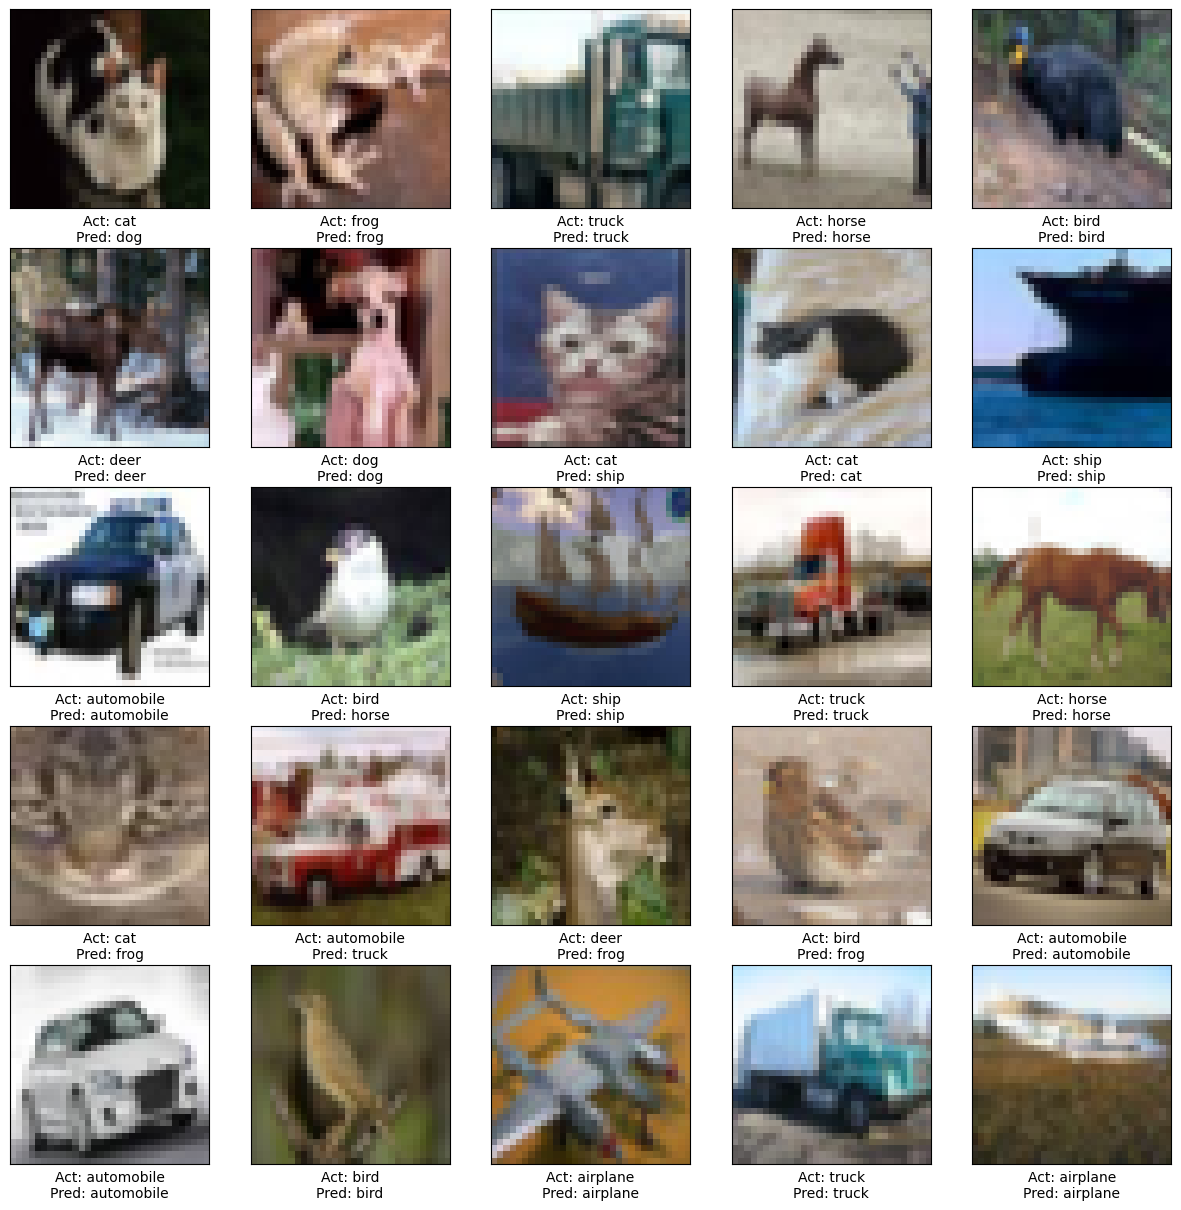

In [65]:
def plot_images(images, actual_labels, predicted_labels, class_names):
    plt.figure(figsize=(15, 15))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(f"Act: {class_names[actual_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
    plt.show()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly select some images and their corresponding actual and predicted labels
indices = np.random.choice(range(len(test_images)), 25, replace=False)
sample_images = test_images[indices]
sample_actual_labels = actual_labels[indices]
sample_predicted_labels = ensemble_pred[indices]

plot_images(sample_images, sample_actual_labels, sample_predicted_labels, class_names)

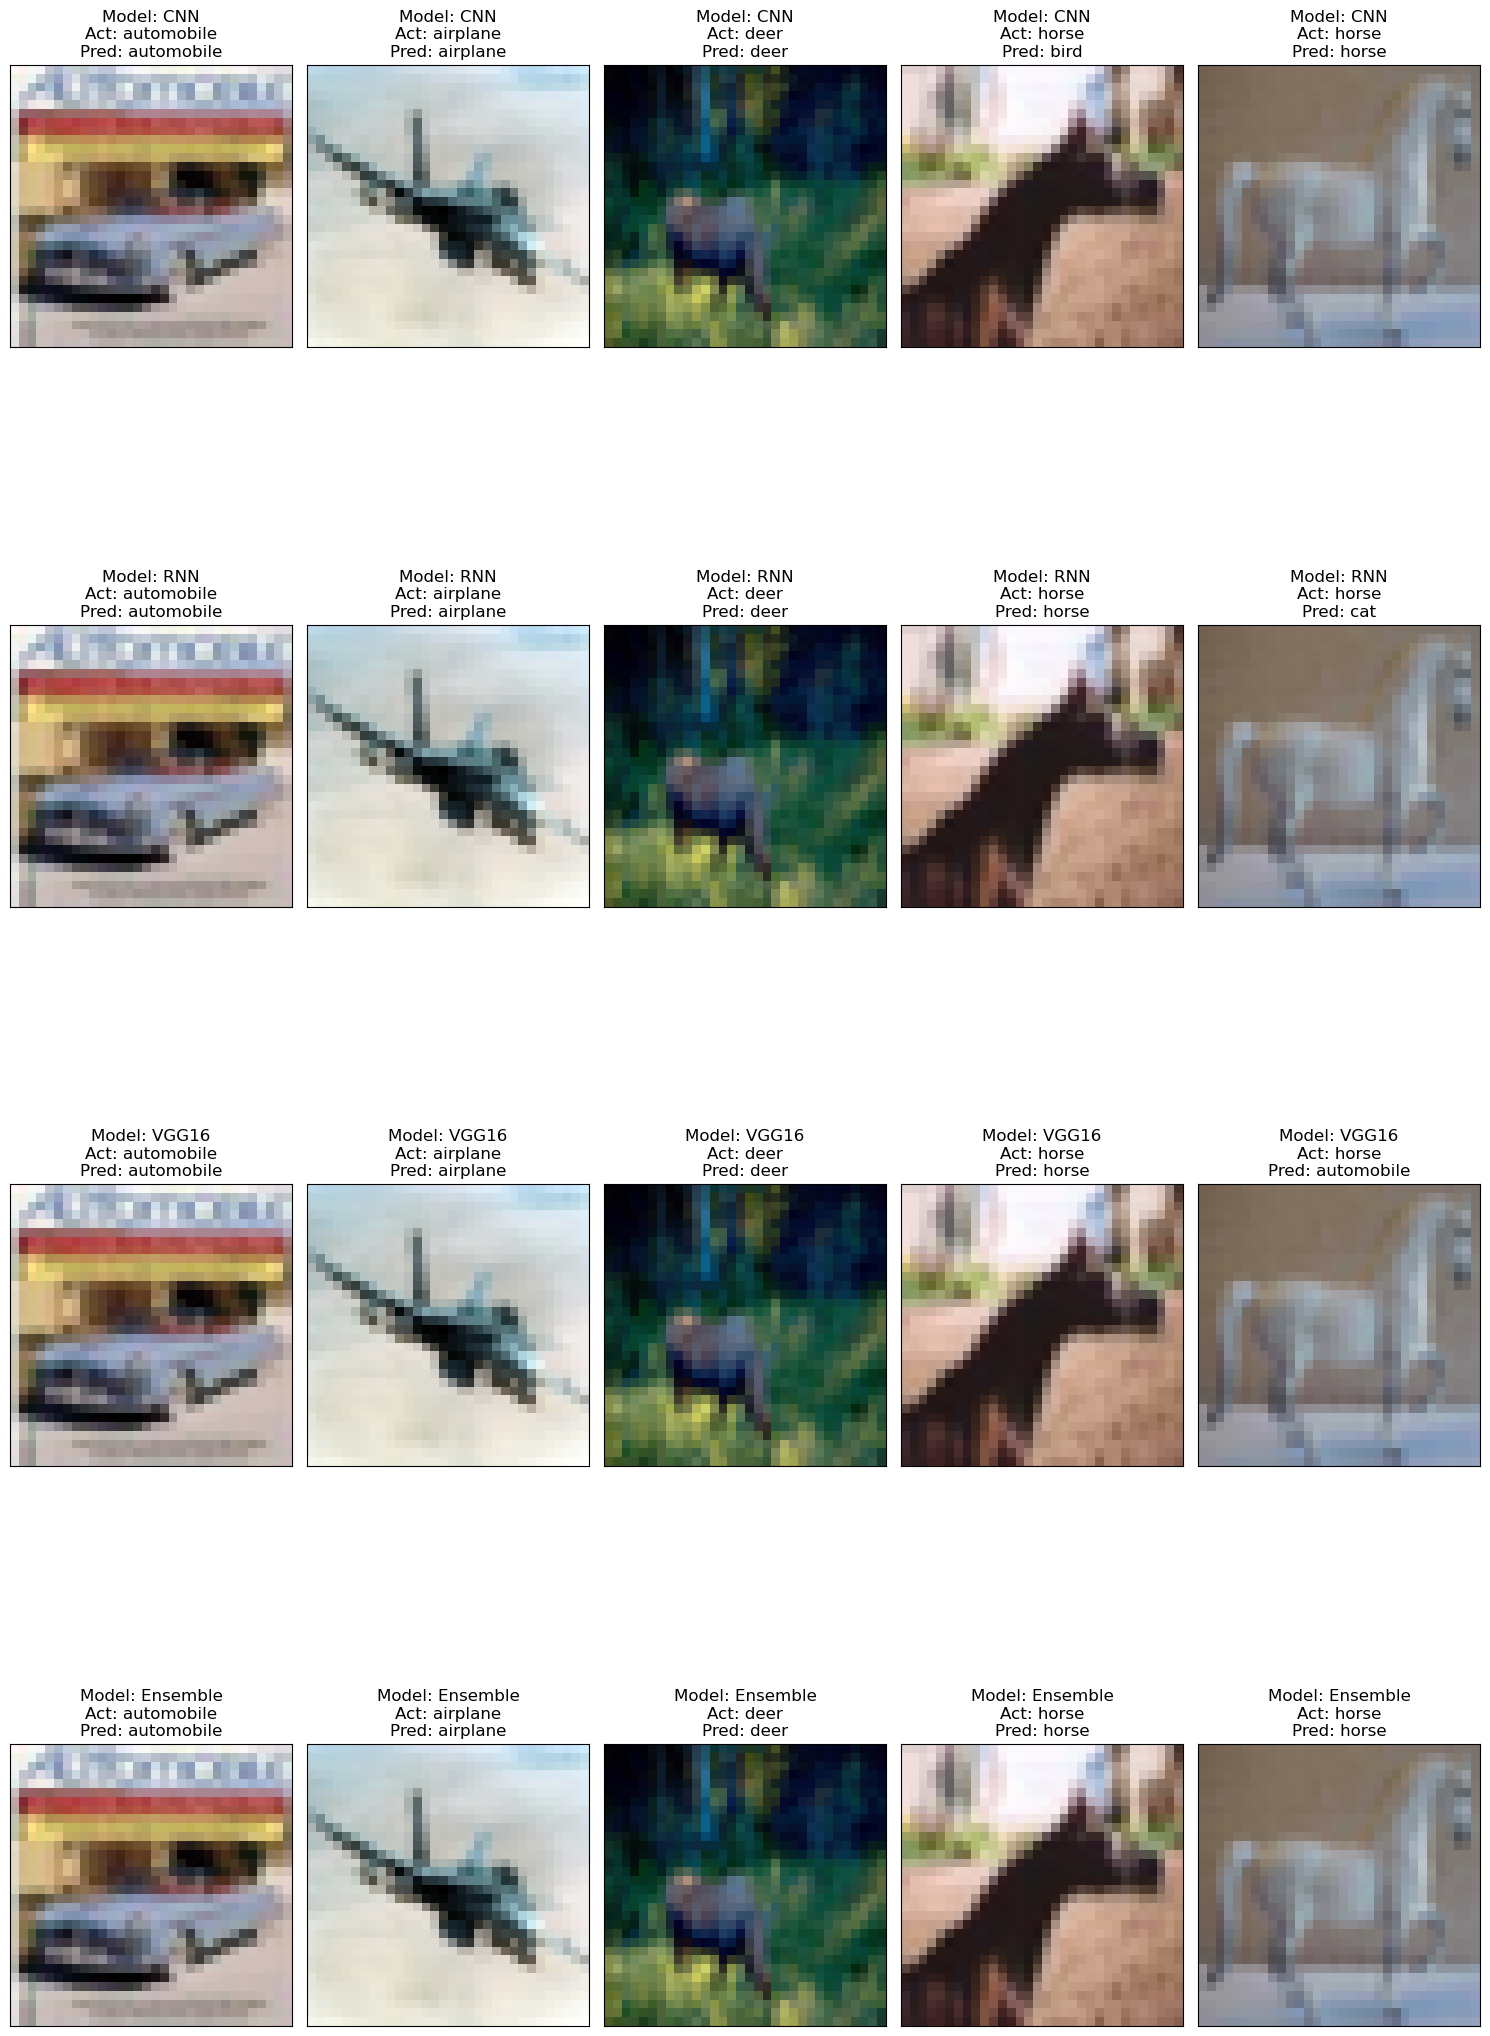

In [81]:
import matplotlib.pyplot as plt

def plot_comparison(images, actual_labels, preds, model_names, class_names):
    num_models = len(preds)
    num_images = images.shape[0]
    
    plt.figure(figsize=(15, 6 * num_models))
    
    for i in range(num_images):
        for j in range(num_models):
            ax = plt.subplot(num_models, num_images, i + 1 + j * num_images)
            ax.imshow(images[i], cmap=plt.cm.binary)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Model: {model_names[j]}\nAct: {class_names[actual_labels[i]]}\nPred: {class_names[preds[j][i]]}")
    
    plt.tight_layout()
    plt.show()

pred_labels1 = np.argmax(pred1, axis=1)
pred_labels2 = np.argmax(pred2, axis=1)
pred_labels3 = np.argmax(pred3, axis=1)

# Select a few images to display
indices = np.random.choice(range(len(test_images)), 5, replace=False)
sample_images = test_images[indices]
sample_actual_labels = actual_labels[indices]
sample_preds = [pred_labels1[indices], pred_labels2[indices], pred_labels3[indices], ensemble_pred[indices]]

model_names = ['CNN', 'RNN', 'VGG16', 'Ensemble']
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plot_comparison(sample_images, sample_actual_labels, sample_preds, model_names, class_names)

In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

meta_pred = meta_model.predict(stacked_features)

# Convert softmax outputs to class predictions
pred1_classes = np.argmax(pred1, axis=1)
pred2_classes = np.argmax(pred2, axis=1)
pred3_classes = np.argmax(pred3, axis=1)
meta_pred_classes = np.argmax(meta_pred, axis=1)

actual_labels = np.argmax(test_labels, axis=1)

# function to calculate metrics
def calculate_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")
    return accuracy, precision, recall, f1

# Calculate and print metrics for each model
calculate_metrics(actual_labels, pred1_classes, "CNN Model")
calculate_metrics(actual_labels, pred2_classes, "RNN Model")
calculate_metrics(actual_labels, pred3_classes, "VGG16 Model")
calculate_metrics(actual_labels, meta_pred_classes, "Meta-Model")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Results for CNN Model:
Accuracy: 0.7891
Precision: 0.8069
Recall: 0.7891
F1 Score: 0.7830


Results for RNN Model:
Accuracy: 0.4986
Precision: 0.4998
Recall: 0.4986
F1 Score: 0.4811


Results for VGG16 Model:
Accuracy: 0.6151
Precision: 0.6113
Recall: 0.6151
F1 Score: 0.6097


Results for Meta-Model:
Accuracy: 0.8352
Precision: 0.8352
Recall: 0.8352
F1 Score: 0.8337




(0.8352, 0.8351959111728323, 0.8352, 0.8337279878236024)

Classification Report for Ensemble Model:
              precision    recall  f1-score   support

    airplane       0.81      0.86      0.83      1000
  automobile       0.84      0.95      0.89      1000
        bird       0.81      0.61      0.70      1000
         cat       0.78      0.46      0.57      1000
        deer       0.80      0.74      0.77      1000
         dog       0.80      0.64      0.71      1000
        frog       0.58      0.96      0.73      1000
       horse       0.83      0.87      0.85      1000
        ship       0.89      0.88      0.89      1000
       truck       0.85      0.88      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.78     10000
weighted avg       0.80      0.79      0.78     10000



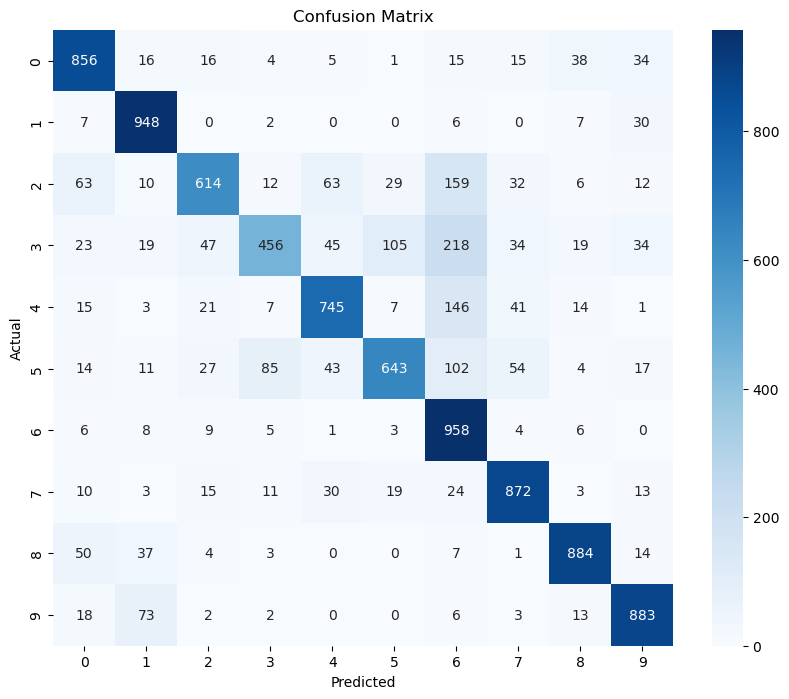

In [109]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert one-hot encoded labels to integers if necessary
true_labels = np.argmax(test_labels, axis=1)  # Only if test_labels are one-hot encoded

# Generate the classification report
report = classification_report(true_labels, ensemble_pred, target_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

print("Classification Report for Ensemble Model:")
print(report)

# Confusion Matrix
cm = confusion_matrix(actual_labels, ensemble_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

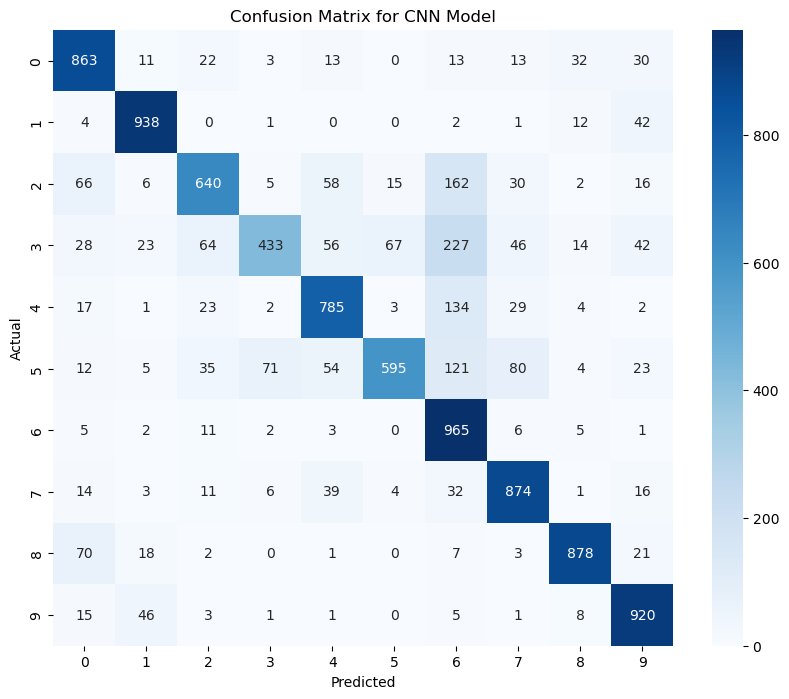

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(actual_labels, pred1_classes, "CNN Model")

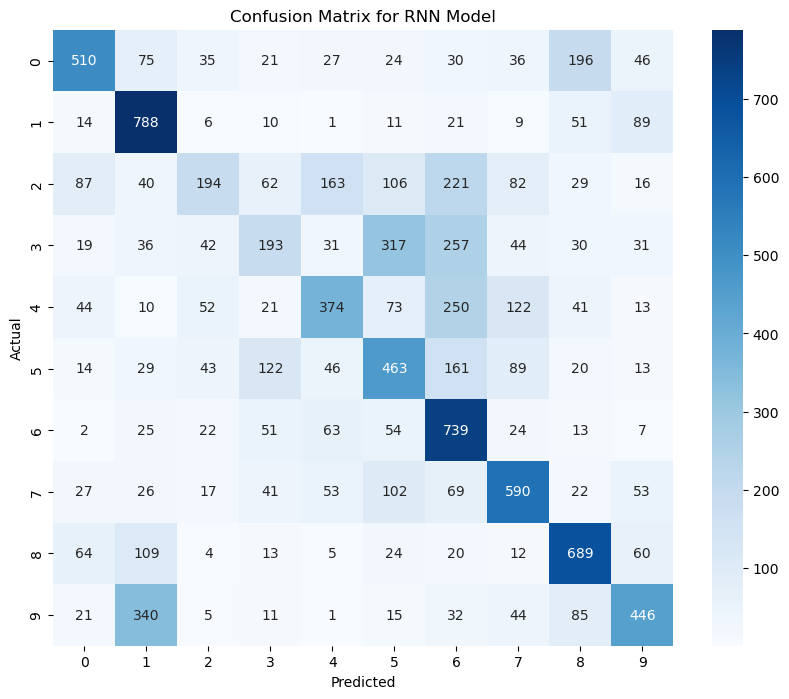

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(actual_labels, pred2_classes, "RNN Model")

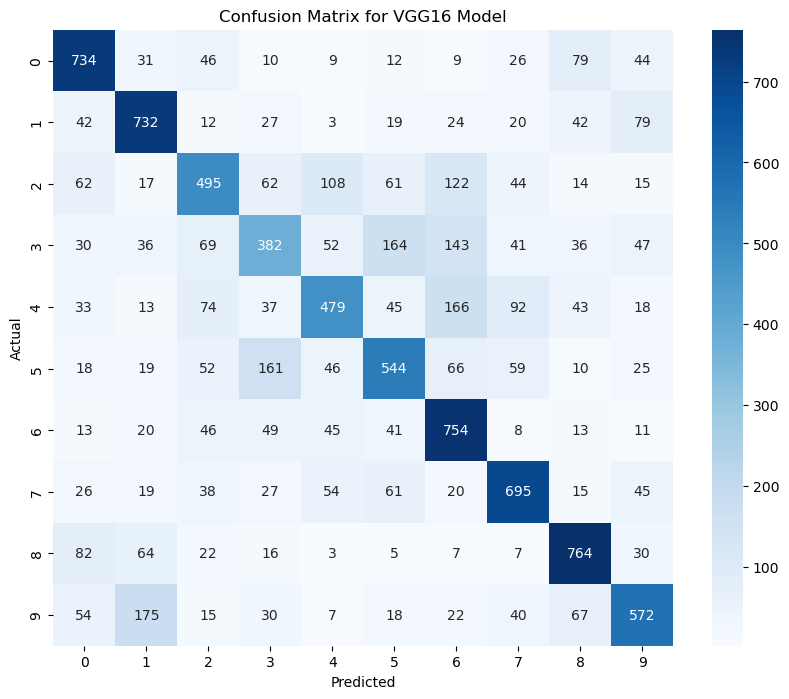

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(actual_labels, pred3_classes, "VGG16 Model")

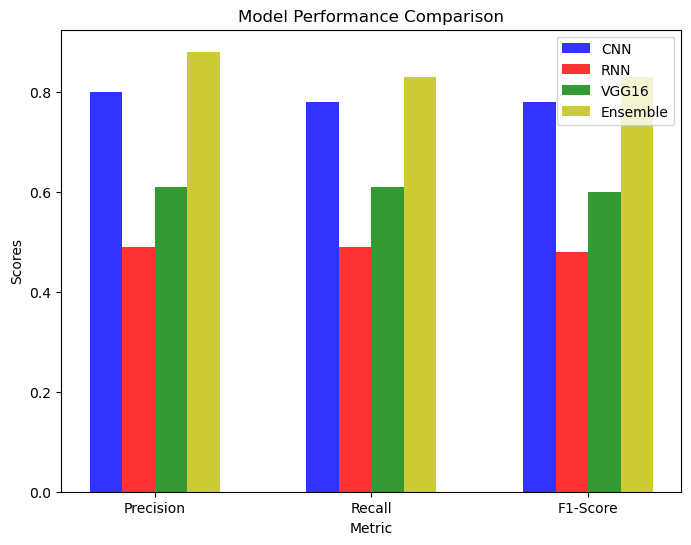

In [95]:
metrics_labels = ['Precision', 'Recall', 'F1-Score']
n_metrics = len(metrics_labels)
fig, ax = plt.subplots(figsize=(8, 6))
index = np.arange(n_metrics)
bar_width = 0.15

cnn_metrics = [0.80, 0.78, 0.78]  # Precision, Recall, F1-Score
rnn_metrics = [0.49, 0.49, 0.48]
vgg_metrics = [0.61, 0.61, 0.60]
ensemble_metrics = [0.88, 0.83, 0.83]

rects1 = ax.bar(index - 1.5 * bar_width, cnn_metrics, bar_width, alpha=opacity, color='b', label='CNN')
rects2 = ax.bar(index - 0.5 * bar_width, rnn_metrics, bar_width, alpha=opacity, color='r', label='RNN')
rects3 = ax.bar(index + 0.5 * bar_width, vgg_metrics, bar_width, alpha=opacity, color='g', label='VGG16')
rects4 = ax.bar(index + 1.5 * bar_width, ensemble_metrics, bar_width, alpha=opacity, color='y', label='Ensemble')

ax.set_xlabel('Metric')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index)
ax.set_xticklabels(metrics_labels)
ax.legend()

plt.show()

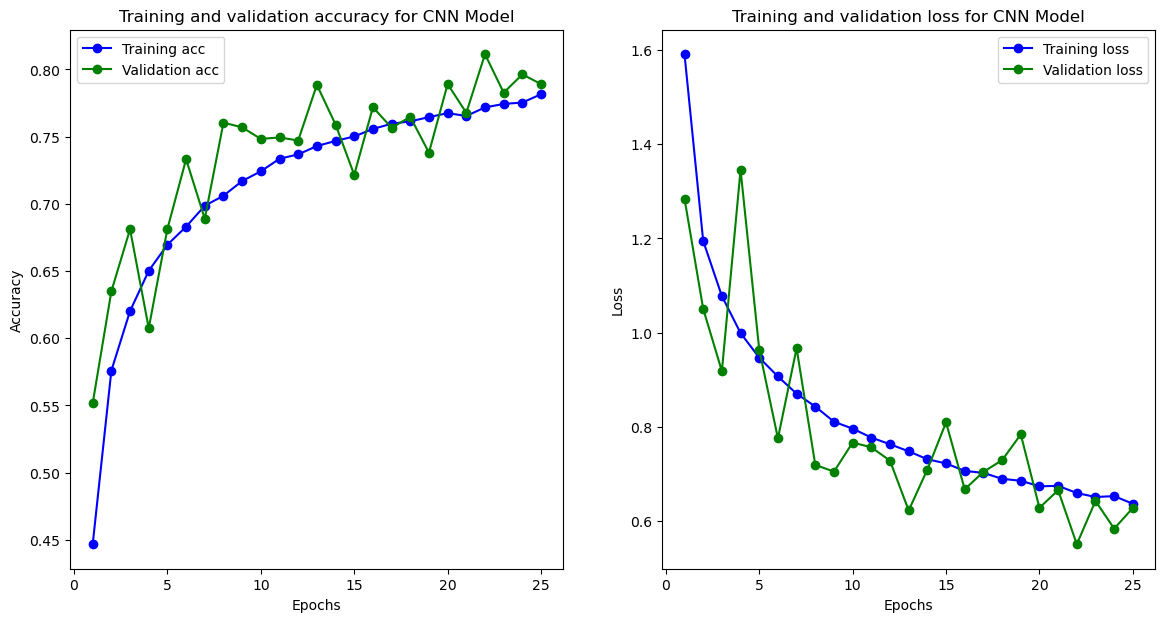

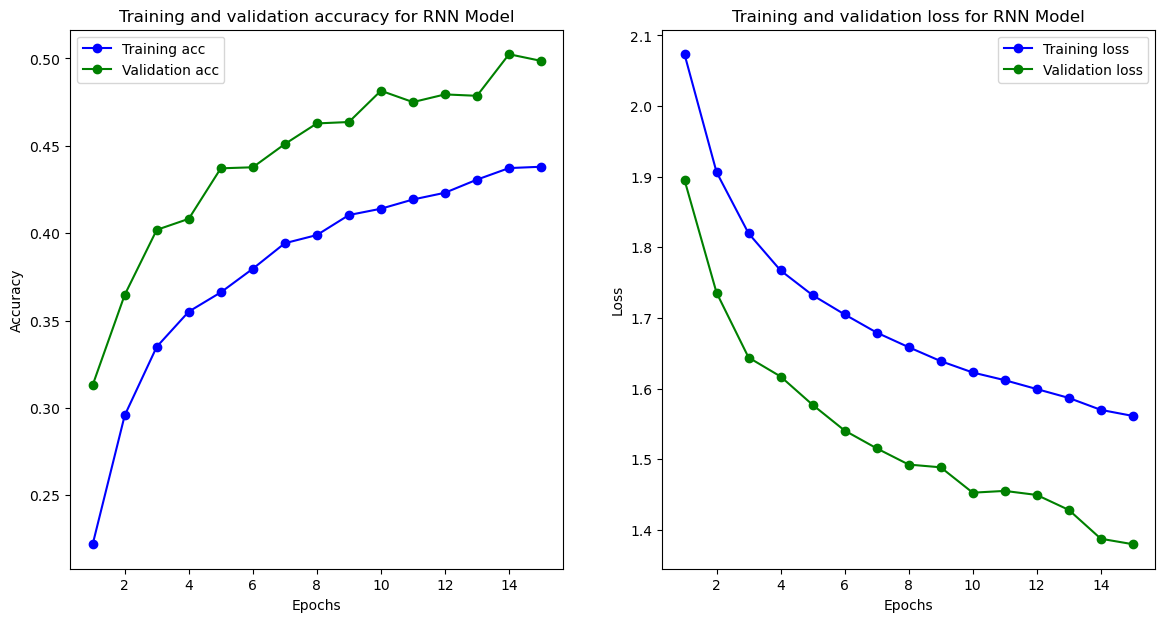

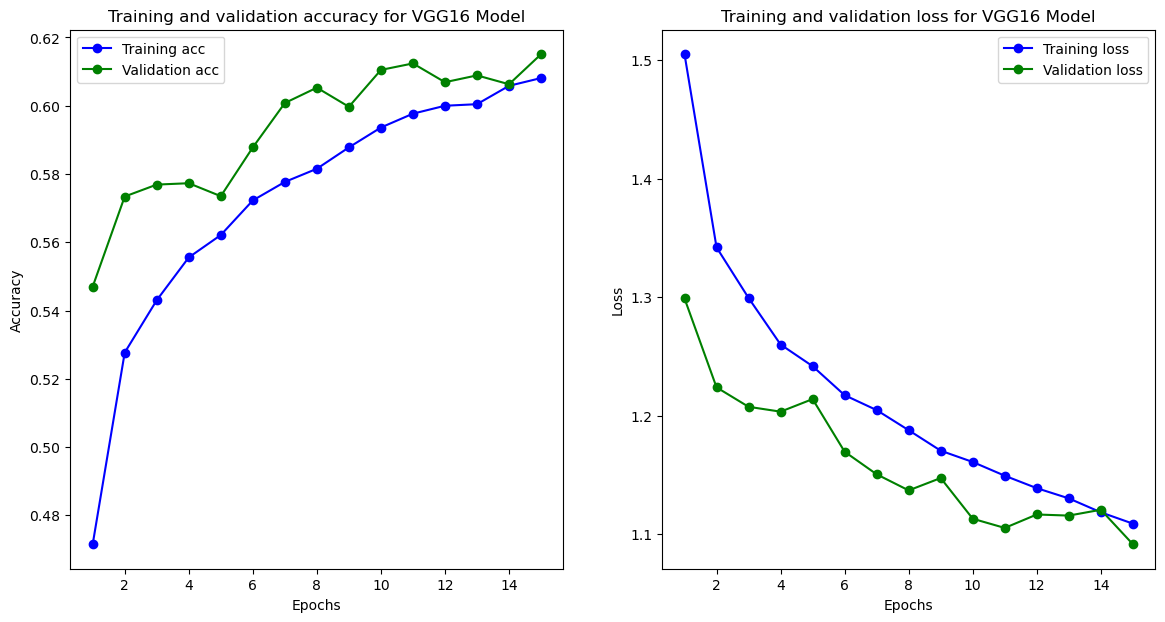

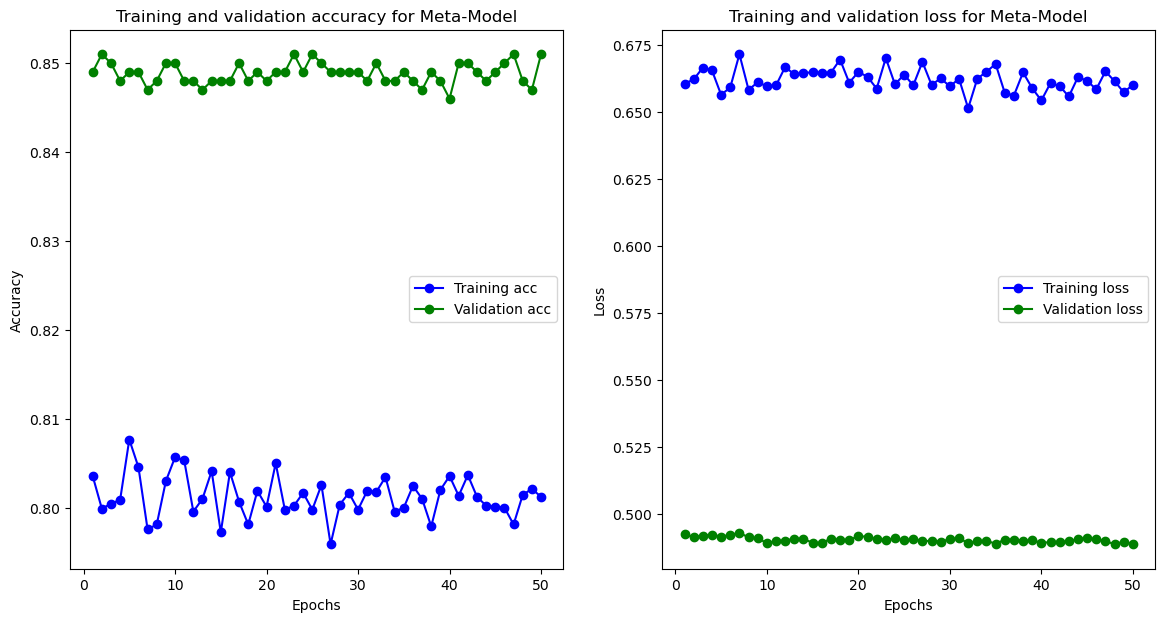

In [101]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'go-', label='Validation acc')
    plt.title(f'Training and validation accuracy for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'go-', label='Validation loss')
    plt.title(f'Training and validation loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history1, "CNN Model")
plot_training_history(history2, "RNN Model")
plot_training_history(history3, "VGG16 Model")
plot_training_history(history_meta, "Meta-Model")

In [106]:
def class_performance(model, test_images, test_labels):
    predictions = np.argmax(model.predict(test_images), axis=1)
    true_labels = np.argmax(test_labels, axis=1)
    report = classification_report(true_labels, predictions, output_dict=True)
    for label in report.keys():
        if label.isdigit():
            print(f"Class {label} - Precision: {report[label]['precision']:.2f}, Recall: {report[label]['recall']:.2f}, F1-score: {report[label]['f1-score']:.2f}")

class_performance(model1, test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Class 0 - Precision: 0.79, Recall: 0.86, F1-score: 0.82
Class 1 - Precision: 0.89, Recall: 0.94, F1-score: 0.91
Class 2 - Precision: 0.79, Recall: 0.64, F1-score: 0.71
Class 3 - Precision: 0.83, Recall: 0.43, F1-score: 0.57
Class 4 - Precision: 0.78, Recall: 0.79, F1-score: 0.78
Class 5 - Precision: 0.87, Recall: 0.59, F1-score: 0.71
Class 6 - Precision: 0.58, Recall: 0.96, F1-score: 0.72
Class 7 - Precision: 0.81, Recall: 0.87, F1-score: 0.84
Class 8 - Precision: 0.91, Recall: 0.88, F1-score: 0.90
Class 9 - Precision: 0.83, Recall: 0.92, F1-score: 0.87


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from sklearn.model_selection import train_test_split

meta_model = Sequential([
    Input(shape=(stacked_features.shape[1],)),  # Use Input layer to specify input shape
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Split data for validation (Example placeholder for cross-validation setup)
X_train, X_val, y_train, y_val = train_test_split(stacked_features, test_labels, test_size=0.1, random_state=42)

# Train the meta-model
meta_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model
evaluation = meta_model.evaluate(X_val, y_val)
print(f"Meta-model Test Loss: {evaluation[0]}")
print(f"Meta-model Test Accuracy: {evaluation[1]}")

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1454 - loss: 2.4726 - val_accuracy: 0.3310 - val_loss: 2.0277
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4752 - loss: 1.6363 - val_accuracy: 0.7390 - val_loss: 1.4068
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6185 - loss: 1.3192 - val_accuracy: 0.7800 - val_loss: 0.9564
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6740 - loss: 1.1167 - val_accuracy: 0.7880 - val_loss: 0.8087
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7038 - loss: 1.0313 - val_accuracy: 0.7930 - val_loss: 0.7510
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7234 - loss: 0.9340 - val_accuracy: 0.7950 - val_loss: 0.7143
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7488 - loss: 0.8742 - val_accuracy: 0.7990 - val_loss: 0.6935
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7562 - loss: 0.8552 - val_accuracy: 0.

In [123]:
pred1 = model1.predict(test_images)
pred2 = model2.predict(test_images)
pred3 = model3.predict(test_images)
meta_pred = meta_model.predict(stacked_features)  # This is for the stacked meta-model

# Convert probabilities to class labels
pred1_classes = np.argmax(pred1, axis=1)
pred2_classes = np.argmax(pred2, axis=1)
pred3_classes = np.argmax(pred3, axis=1)
meta_pred_classes = np.argmax(meta_pred, axis=1)
actual_labels = np.argmax(test_labels, axis=1)  # CHange one-hot encoding if necessary
from sklearn.metrics import accuracy_score

accuracy1 = accuracy_score(actual_labels, pred1_classes)
accuracy2 = accuracy_score(actual_labels, pred2_classes)
accuracy3 = accuracy_score(actual_labels, pred3_classes)
meta_accuracy = accuracy_score(actual_labels, meta_pred_classes)
print("Model Accuracies Comparison:")
print(f"CNN Model Accuracy: {accuracy1:.2%}")
print(f"RNN Model Accuracy: {accuracy2:.2%}")
print(f"VGG16 Model Accuracy: {accuracy3:.2%}")
print(f"Meta-Model (Stacked Ensemble) Accuracy: {meta_accuracy:.2%}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
Model Accuracies Comparison:
CNN Model Accuracy: 78.91%
RNN Model Accuracy: 49.86%
VGG16 Model Accuracy: 61.51%
Meta-Model (Stacked Ensemble) Accuracy: 83.48%
